In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import os


In [43]:
def plot_data(data):
    plt.plot(data["t"], data["θr"])
    plt.xlabel("t")
    plt.ylabel("θr")

In [44]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean()

In [45]:
def format_pd(data):
    data = data.dropna()
    # Arranca en t = 0
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    data = data[data["t"] <=5]
    return data

In [46]:
def get_tita0(data):
    try:
        return data["θr"].iloc[0]
    except KeyError:
        return data["θ"].iloc[0]

def get_amplitud(data):  # asumo amplitud como Asen(θ)
    try:
        return (max(data["θr"]) - min(data["θr"])) / 2
    except KeyError:
        return (max(data["θ"]) - min(data["θ"])) / 2

def get_periodo(data):
    try:
        # Localizo un máximo y un mínimo
        maximo = data["θ"].idxmax()
        minimo = data["θ"].idxmin()
        # Calculo el periodo
        return abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2 # *2 porque es de pico a pico
    except KeyError:
        # Localizo un máximo y un mínimo
        maximo = data["θr"].idxmax()
        minimo = data["θr"].idxmin()
        # Calculo el periodo
        return abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2 # *2 porque es de pico a pico

def get_frecuencia(data):
    return 1 / get_periodo(data) # NO está en rad/sec, está en Hz

In [47]:
# def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
#     x = data["t"]
#     print(x[0])
#     delta = np.arcsin(tita0 / amplitud)
#     y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
#     print(y[0])
#     plt.plot(x, y)

In [48]:
import math

rm = 1
drm = 0.1

def error_propagation_tita_from_rm_L(L, dL):
    return math.sqrt((L / (drm**2 + L**2))**2 + (rm / (dL**2 + rm**2))**2)

def gen_dθr(L):
    return math.atan(rm/L) + error_propagation_tita_from_rm_L(L, 0.1)

def gen_dicc_with_deltas(dicc, data):
    #data is a pandas dataframe with columns t, x, y, r, tita
    dicc["dx"] = 0.1
    dicc["dy"] = 0.1
    dicc["dr"] = 0.1
    dicc["dt"] = 1/30
    L = data["r"].mean()
    dicc["dθr"] = gen_dθr(L)
    dicc["dθ0"] = dicc["dθr"]
    dicc["L"] = L

def gen_dicc(data):
    dicc = {}
    dicc["drm"] = 0.1
    gen_dicc_with_deltas(dicc, data)
    return dicc

0: oro l1\oro35.csv


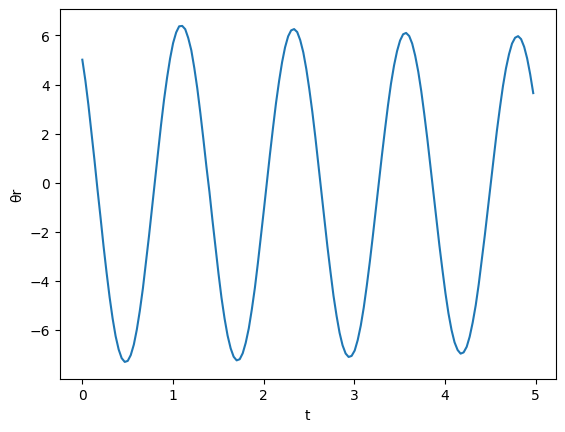

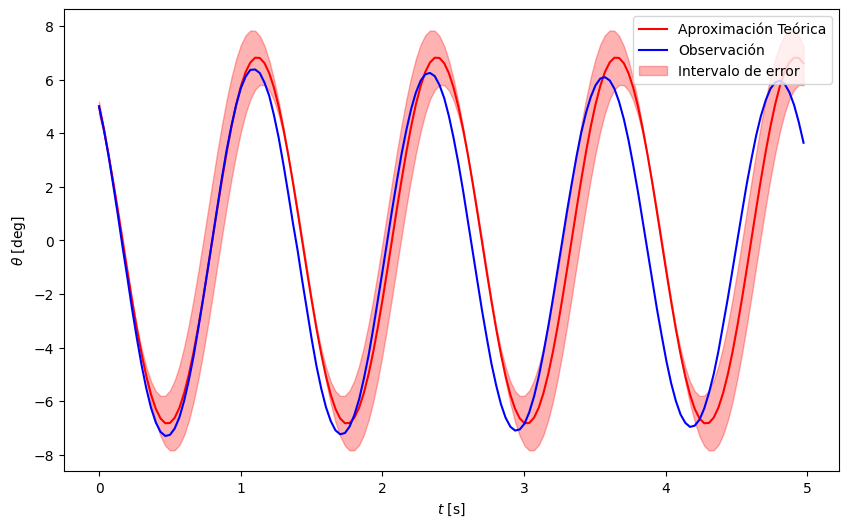

1: oro l1\oro40.csv


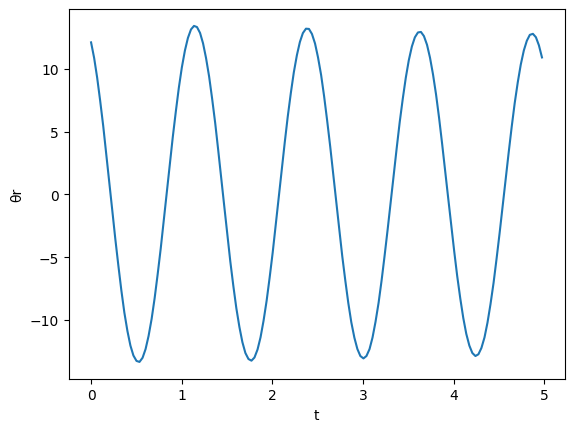

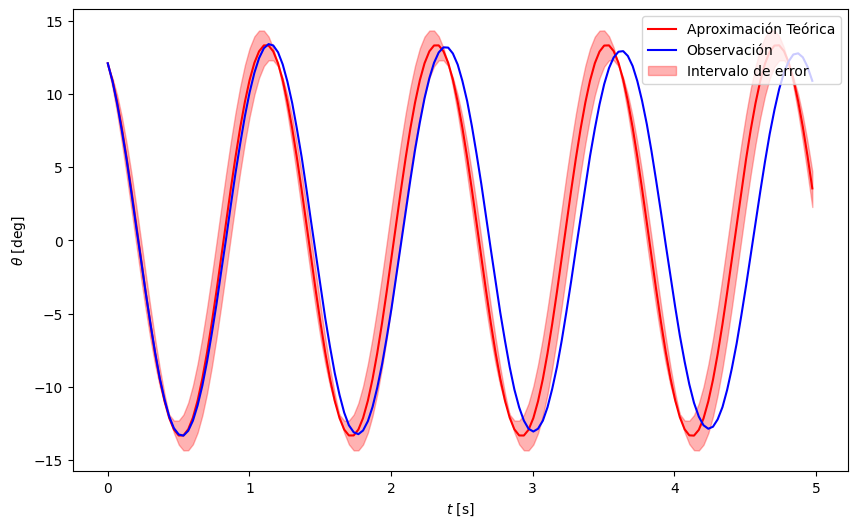

2: oro l1\oro45.csv


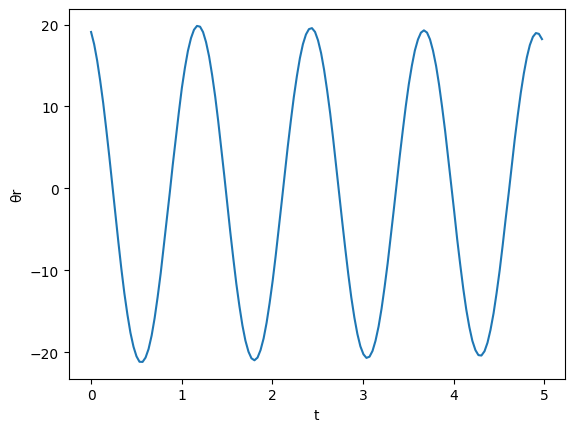

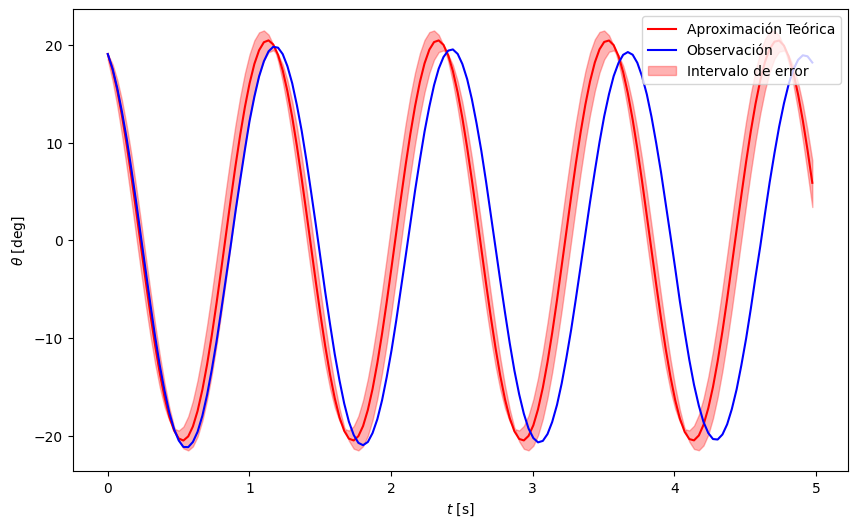

3: oro l1\oro50.csv


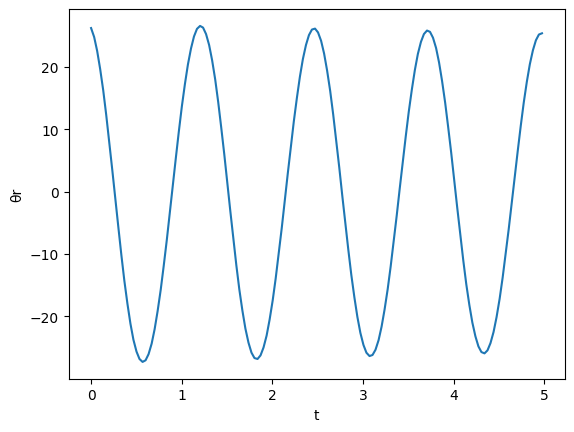

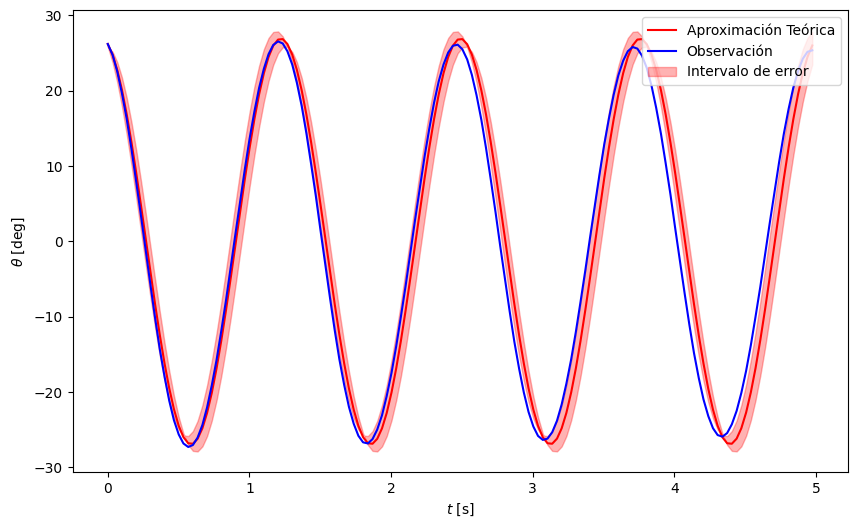

4: plata l0\plata35.csv


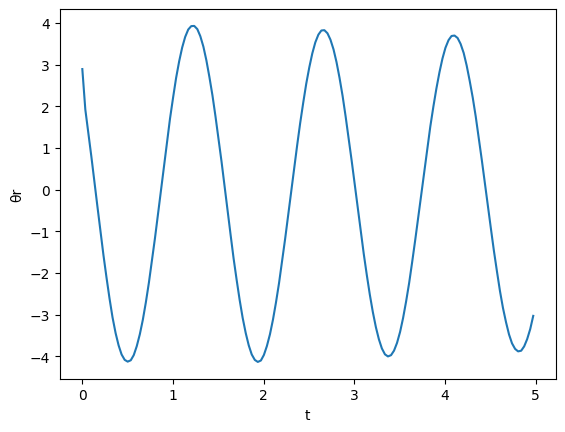

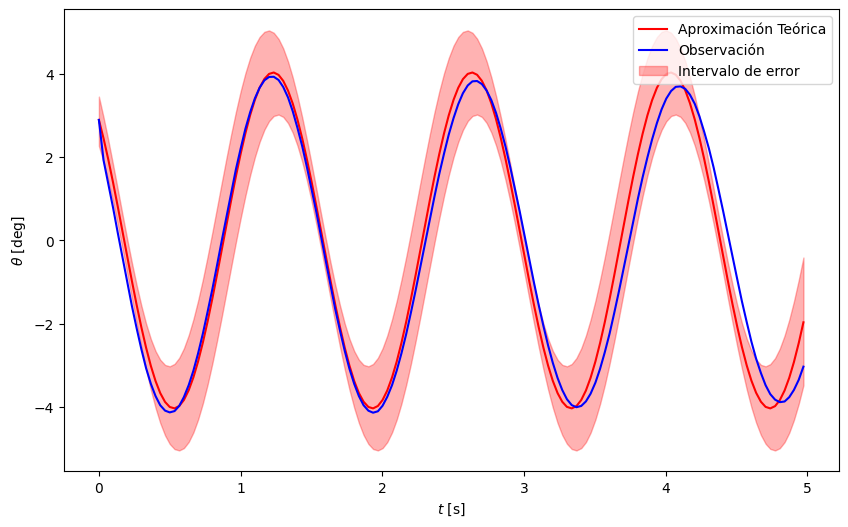

5: plata l0\plata40.csv


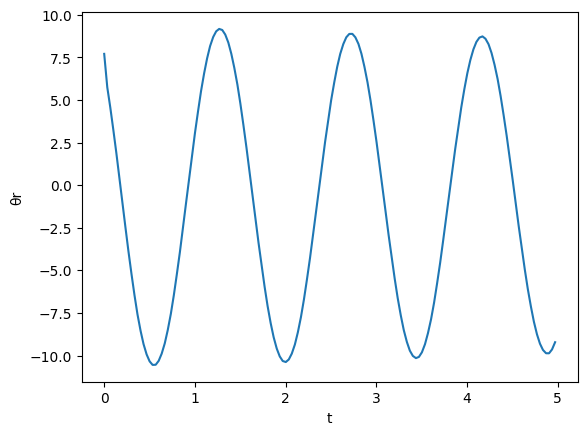

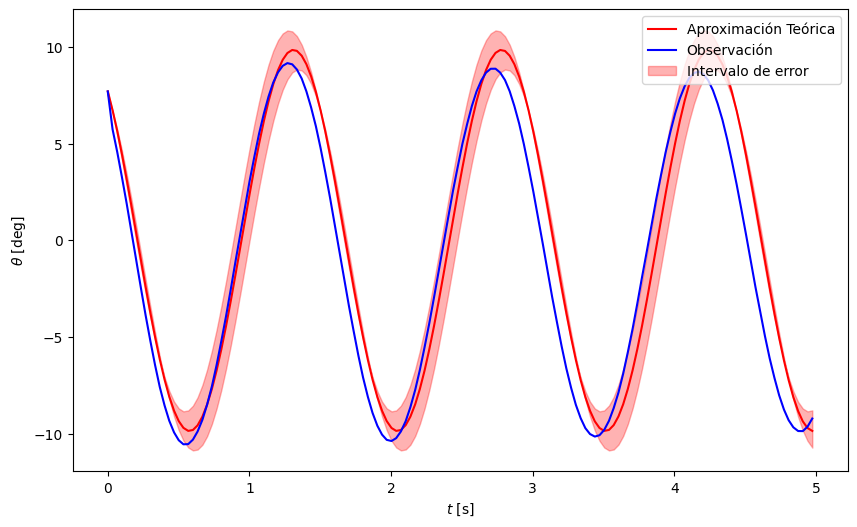

6: plata l0\plata50.csv


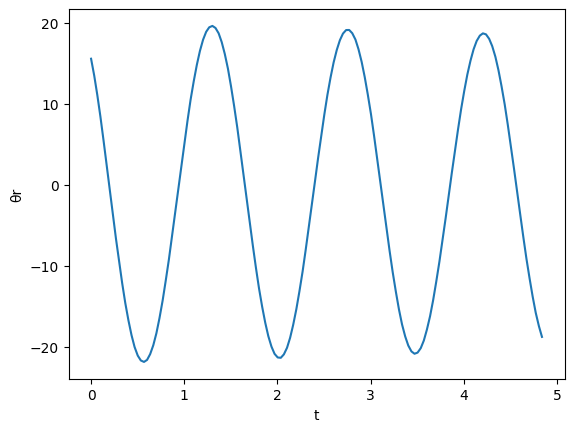

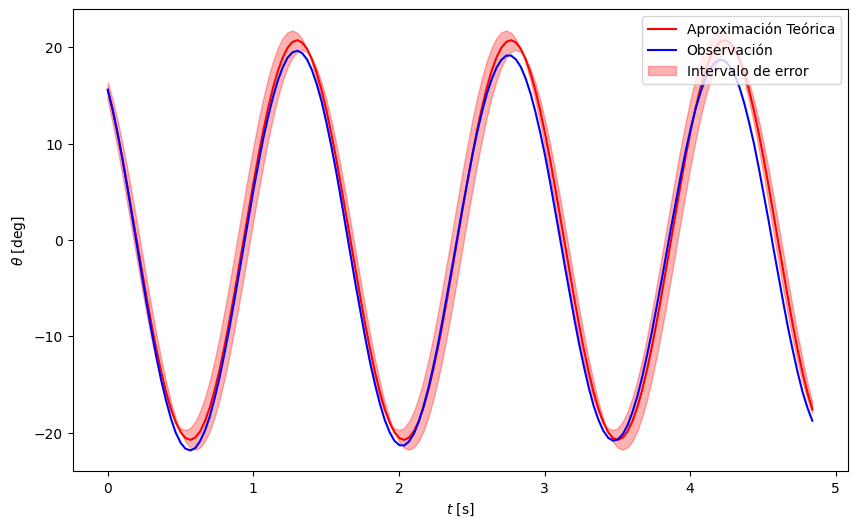

7: plata l0\plata60.csv


C:\Users\xxx\AppData\Local\Temp\ipykernel_2292\519347163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


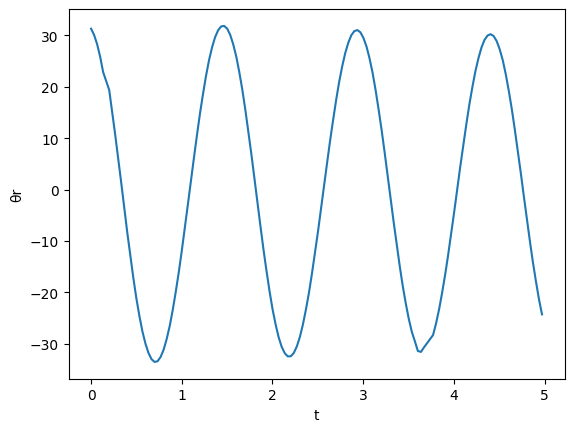

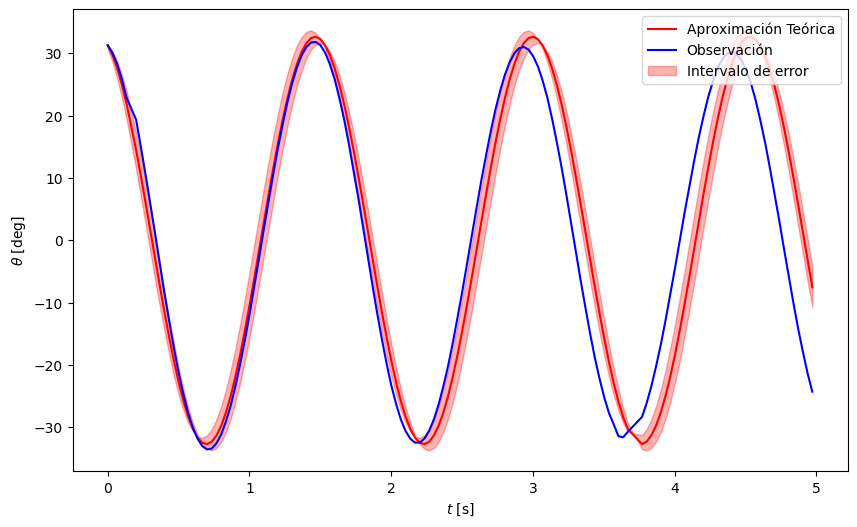

8: plata l1\plata35.csv


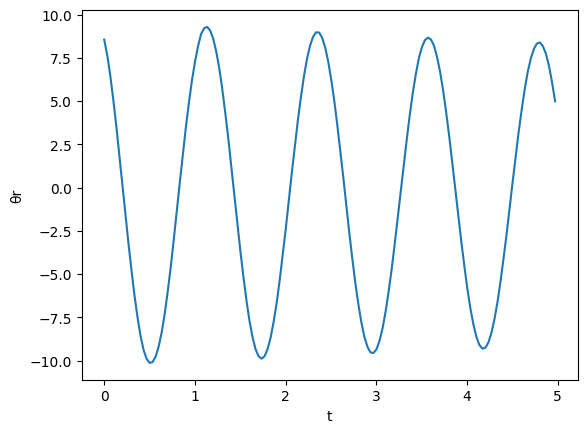

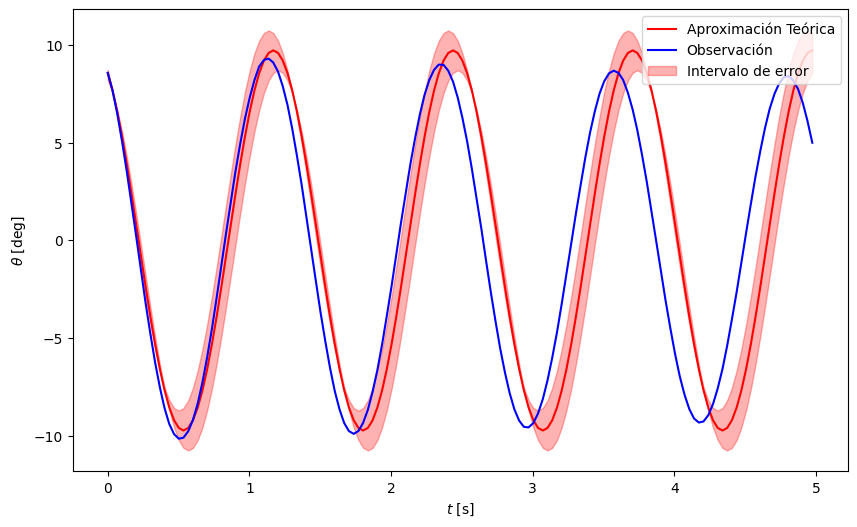

9: plata l1\plata40.csv


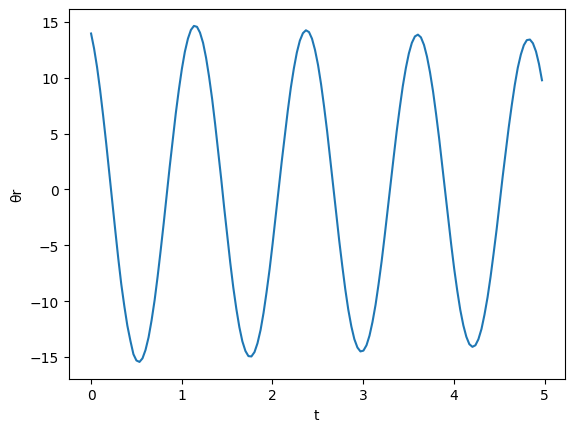

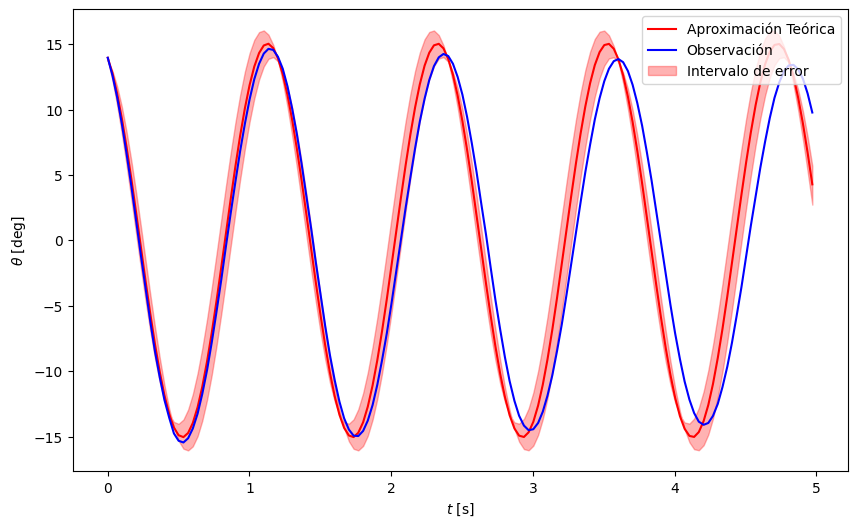

10: plata l1\plata45.csv


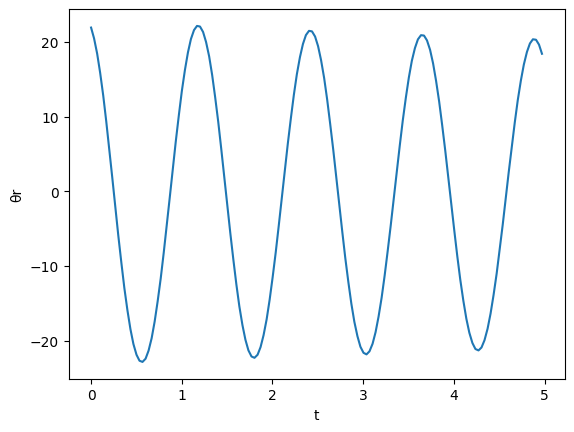

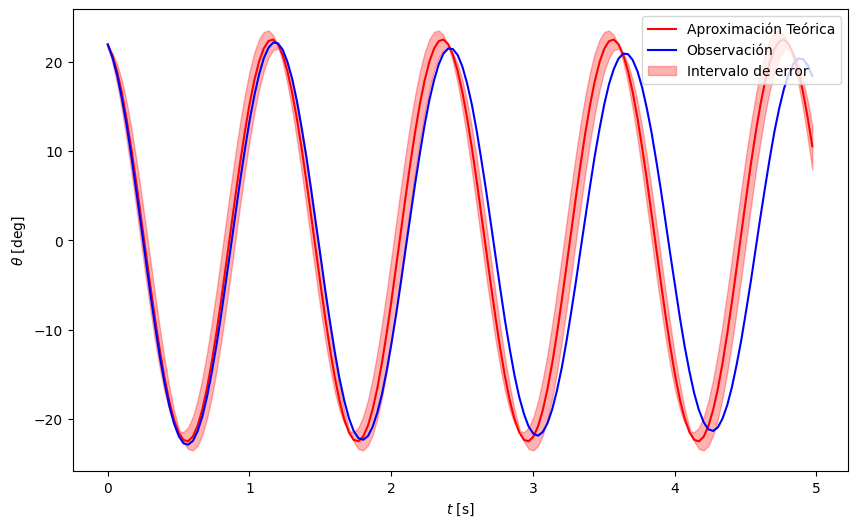

11: plata l1\plata50.csv


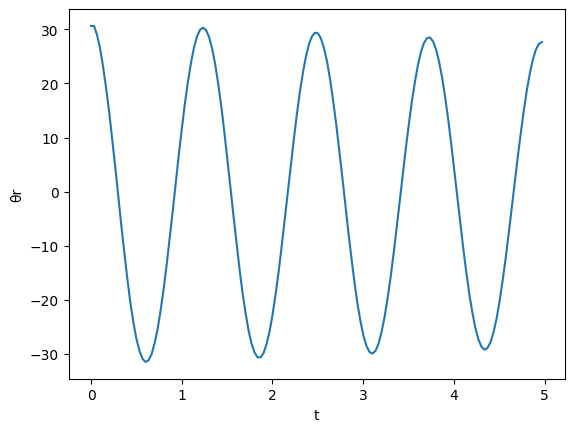

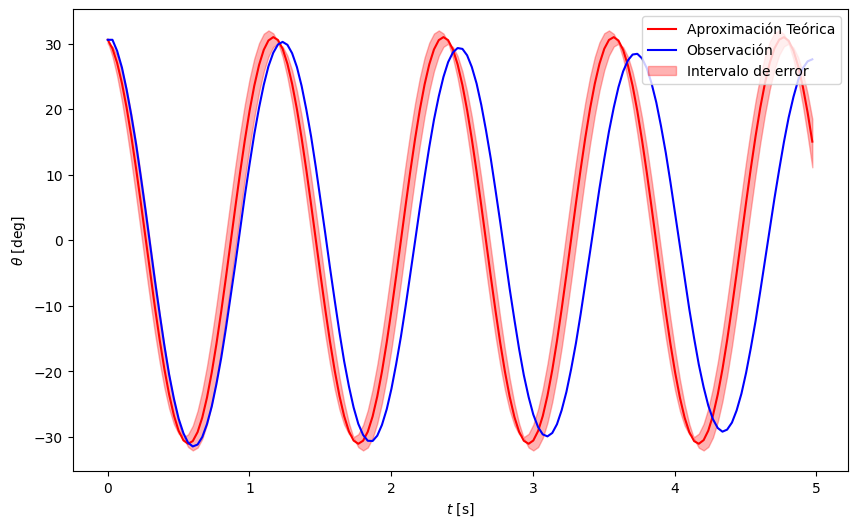

12: plata l2\plata35.csv


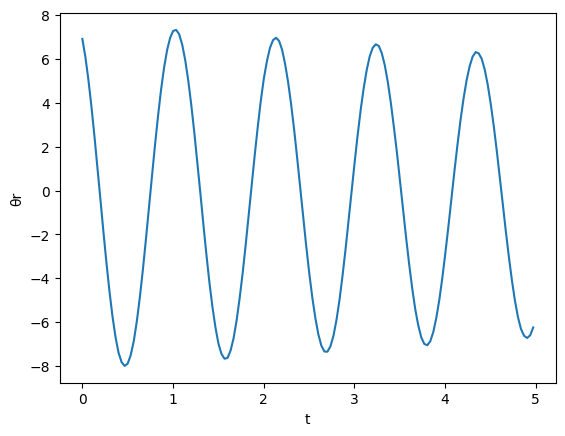

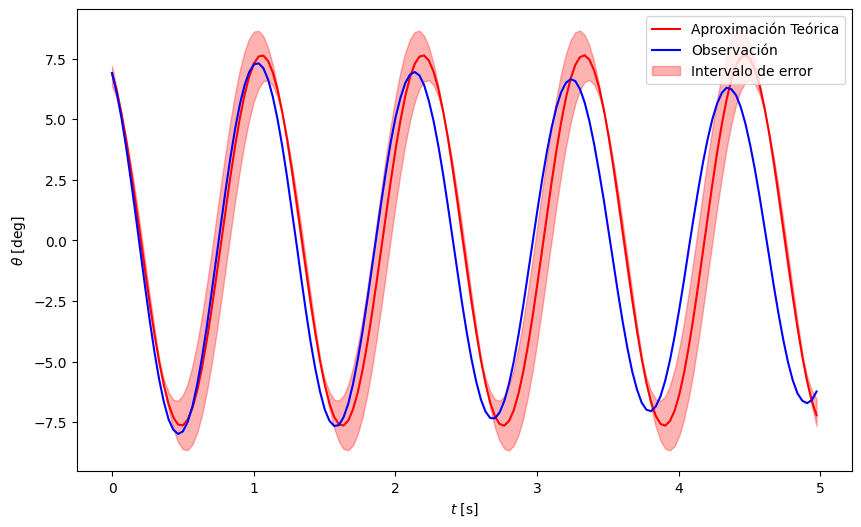

13: plata l2\plata40.csv


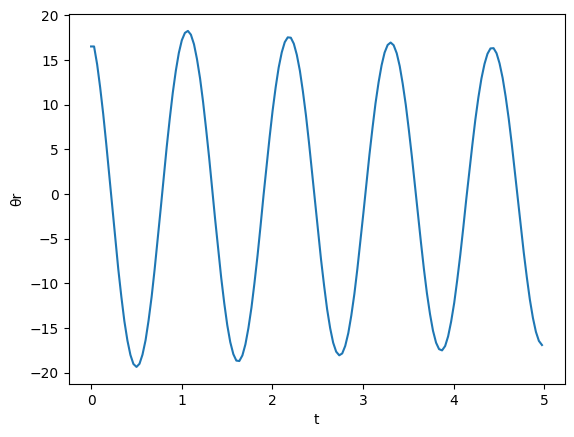

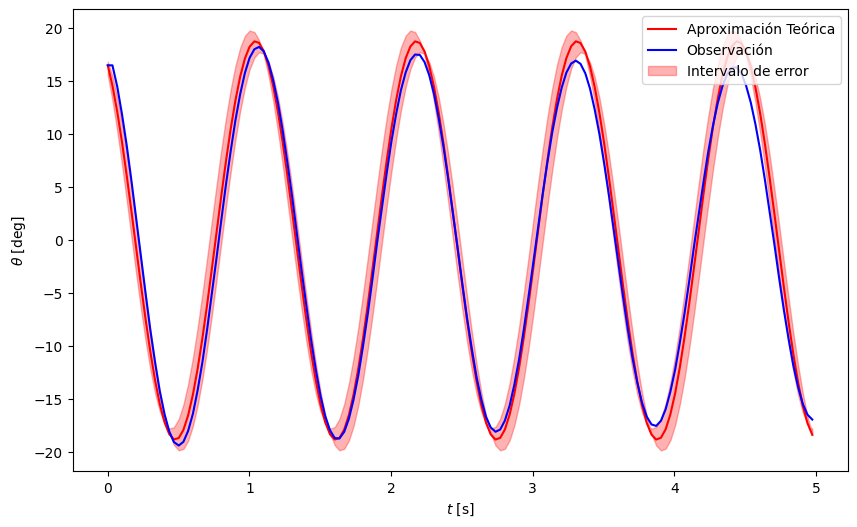

14: plata l3\plata35.csv


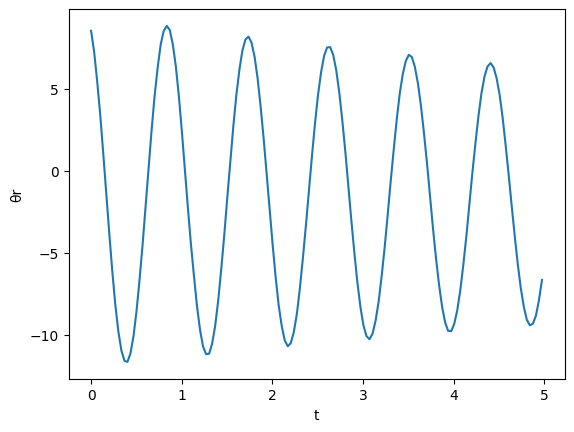

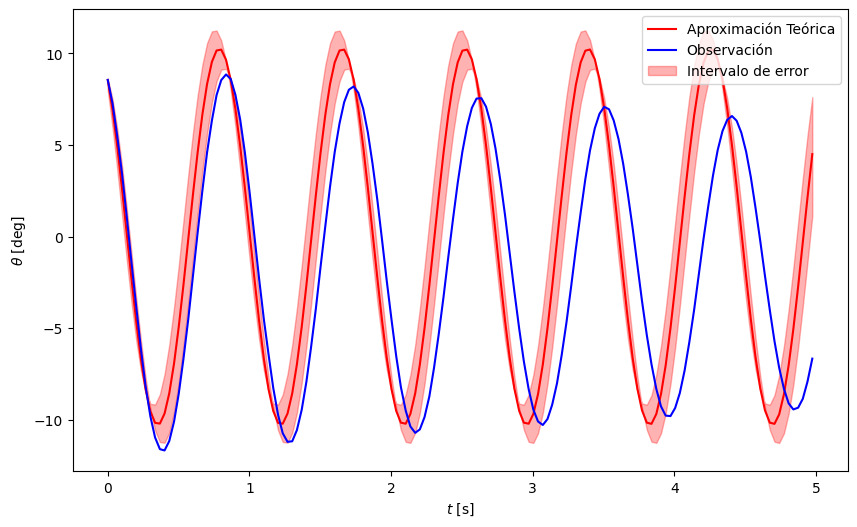

15: plata l3\plata40.csv


C:\Users\xxx\AppData\Local\Temp\ipykernel_2292\3933639155.py:4: RuntimeWarning: invalid value encountered in arcsin
  delta = np.arcsin(tita0 / amplitud)


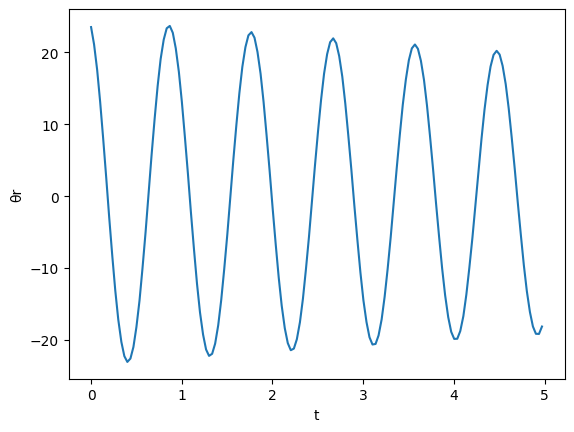

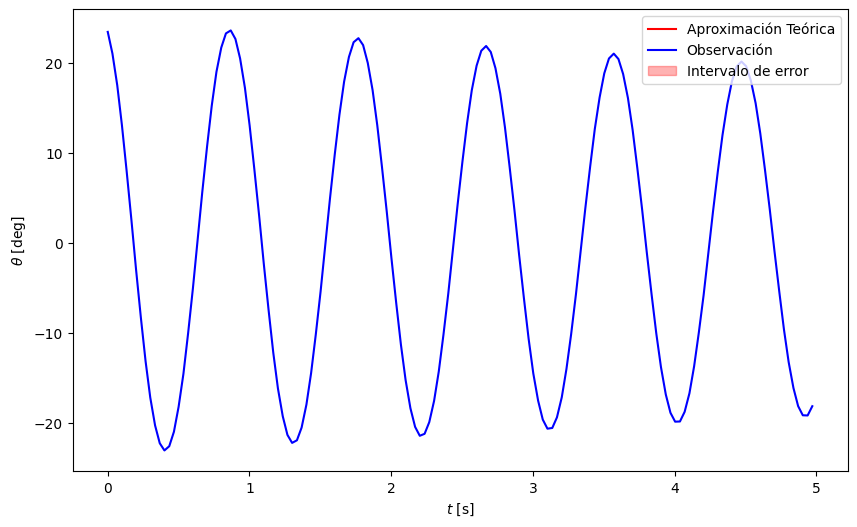

16: plata l3\plata45.csv


C:\Users\xxx\AppData\Local\Temp\ipykernel_2292\3933639155.py:28: RuntimeWarning: invalid value encountered in arcsin
  delta = np.arcsin(tita0 / amplitud)
C:\Users\xxx\AppData\Local\Temp\ipykernel_2292\3933639155.py:121: RuntimeWarning: invalid value encountered in scalar divide
  propagation = np.sqrt(np.sum(((y - y_hat)**2) * (sigma_y**2 + sigma_y_hat**2)) / (n * rmse**2))


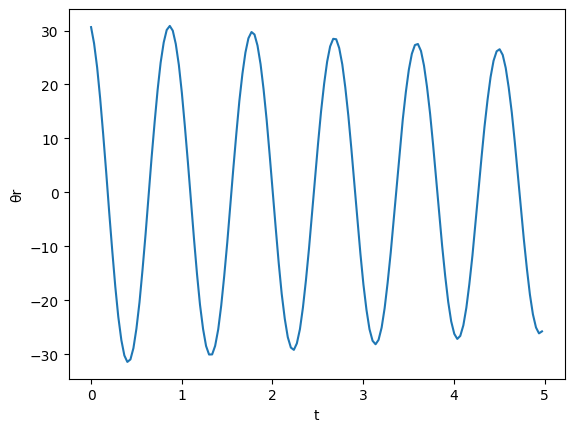

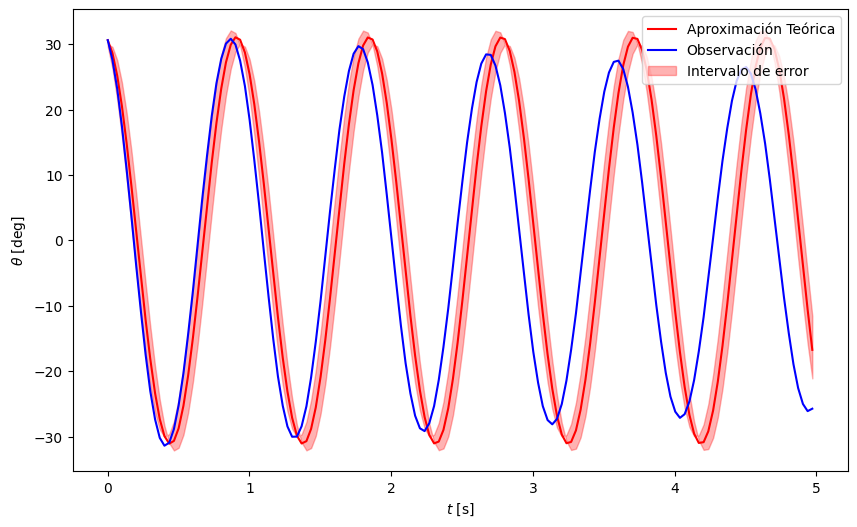

17: plata l3\plata50.csv


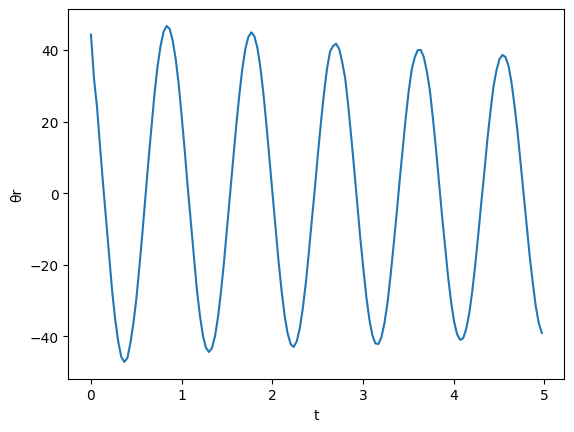

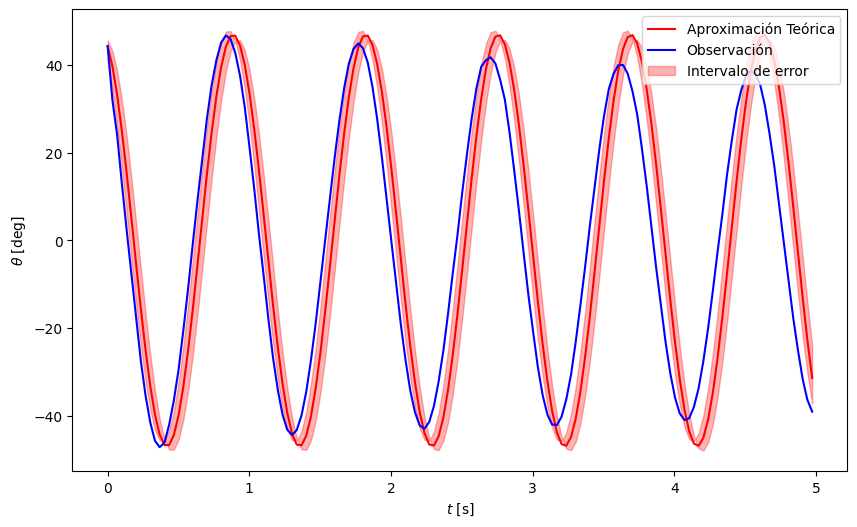

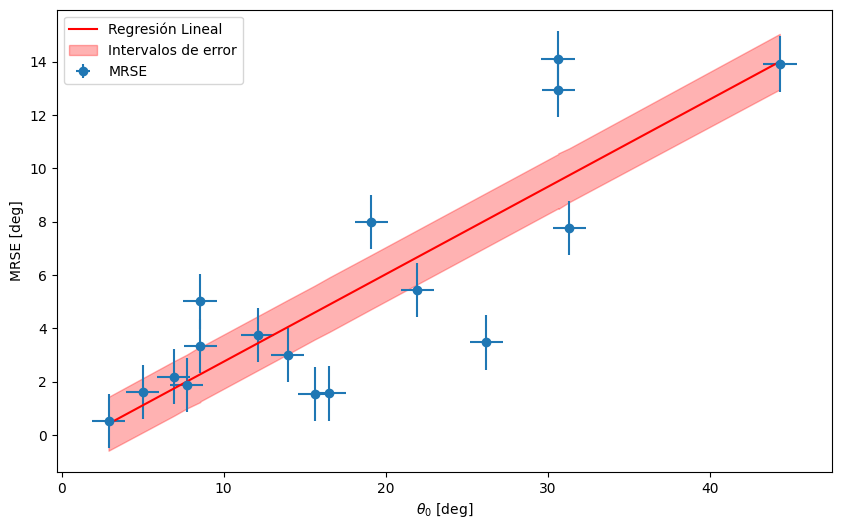

In [49]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
    dicc = gen_dicc(data)
    x = data["t"]
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)

    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(x, y, color="red", label=r'Aproximación Teórica')  # Señal teórica
    plt.plot(x, data["θr"], color="blue", label=r'Observación')  # Señal observada

    y_izq = amplitud * np.sin(2 * np.pi * (-frecuencia) * (x - dicc["dt"]) + delta) - dicc["dθr"]
    y_der = amplitud * np.sin(2 * np.pi * (-frecuencia) * (x + dicc["dt"]) + delta) + dicc["dθr"]
    plt.fill_between(x, 
                     y_izq,
                     y_der,
                     color="red", alpha=0.3, label=r'Intervalo de error')
    plt.xlabel(r'$t$ [s]')
    plt.ylabel(r'$\theta$ [deg]')
    
    # Modificación del título para incluir el ángulo inicial
    #plt.title(f'Aproximación Teórica (θ₀ = {tita0:.2f})')  # Añadiendo θ₀ al título
    
    plt.legend(loc='upper right')
    plt.show()

def calculate_theoretical_signal(data, tita0, amplitud, frecuencia, T):
    x = data["t"]
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    return y

def load_datasets(input_dir):
    datasets = []
    for folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.csv'):
                    datasets.append(os.path.join(folder, file))
    return datasets

def process_dataset(dataset_path):
    data = pd.read_csv(dataset_path)
    L = get_largo(data)
    data = format_pd(data)
    plot_data(data)
    tita0, amplitud, T, frecuencia = get_tita0(data), get_amplitud(data), get_periodo(data), get_frecuencia(data)
    return data, tita0, amplitud, T, frecuencia

def plot_MSE(data, theoretical_signal):
    try:
        squared_error = (data['θr'] - theoretical_signal) ** 2
    except KeyError:
        squared_error = (data['θ'] - theoretical_signal) ** 2
    
    plt.figure()
    plt.plot(data['t'], squared_error, label=r'Error Cuadrático Medio')
    plt.xlabel(r'Tiempo')
    plt.ylabel(r'Error Cuadrático Medio')
    plt.legend()
    #plt.title('Error Cuadrático Medio en el Tiempo')
    plt.show()

def plot_cumulative_error(data, theoretical_signal):
    try:
        absolute_error = np.abs(data['θr'] - theoretical_signal)
    except KeyError:
        print(data)
        absolute_error = np.abs(data['θ'] - theoretical_signal)
    
    cumulative_error = np.cumsum(absolute_error)
    
    plt.figure()
    plt.plot(data['t'], cumulative_error, label=r'Error Absoluto Acumulativo')
    plt.xlabel(r'Tiempo')
    plt.ylabel(r'Error Absoluto Acumulativo')
    plt.legend()
    #plt.title('Error Absoluto Acumulativo en el Tiempo')
    plt.show()

def graph_MRSEs(MRSEs):
    MRSEs = sorted(MRSEs, key=lambda x: x[0])
    tita0_values = [x[0] for x in MRSEs]
    MRSE_values = [x[1] for x in MRSEs]
    tita0_errors = [x[2] for x in MRSEs]
    MRSE_errors = [x[3] for x in MRSEs]
    L_values = [x[4] for x in MRSEs]

    plt.figure(figsize=(10, 6)) 

    # Plotting MRSE with error bars
    plt.errorbar(tita0_values, MRSE_values, xerr=tita0_errors, yerr=MRSE_errors, fmt='o', label=r'MRSE')
    
    # Performing linear regression
    X = np.array(tita0_values).reshape(-1, 1)
    y = np.array(MRSE_values)
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Plotting the linear regression line
    plt.plot(tita0_values, y_pred, color='red', label=r'Regresión Lineal')
    plt.fill_between(tita0_values, y_pred - MRSE_errors, y_pred + MRSE_errors, color='red', alpha=0.3, label=r'Intervalos de error')
    plt.xlabel(r'$\theta_0$ [deg]')
    plt.ylabel(r'MRSE [deg]')
    plt.legend()
    plt.show()

# Definir función para calcular el RMSE
def calculate_rmse(y, y_hat):
    n = len(y)
    rmse = np.sqrt(np.sum((y - y_hat)**2) / n)
    return rmse

# Definir función para la propagación de errores
def calculate_rmse_propagation(y, y_hat, sigma_y_hat, sigma_y=0):
    n = len(y)
    rmse = calculate_rmse(y, y_hat)
    
    # Calcular la propagación de errores
    propagation = np.sqrt(np.sum(((y - y_hat)**2) * (sigma_y**2 + sigma_y_hat**2)) / (n * rmse**2))
    
    return rmse, propagation

def graphs():
    input_dir = os.path.join('..', 'datasets')
    datasets = load_datasets(input_dir)
    
    MRSEs_tita0 = []
     
    for i, dataset in enumerate(datasets):
        print(f"{i}: {dataset}")
        dataset_path = os.path.join(input_dir, dataset)
        data, tita0, amplitud, T, frecuencia = process_dataset(dataset_path)

        dicc = gen_dicc(data)

        plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T)
        
        theoretical_signal = calculate_theoretical_signal(data, tita0, amplitud, frecuencia, T)
        MRSE, dMRSE = calculate_rmse_propagation(data['θr'], theoretical_signal, dicc["dθr"])
        if 23.5 < tita0 < 24.5:
            continue
        MRSEs_tita0.append((tita0, MRSE, dicc["dθ0"], dMRSE, dicc["L"]))
        # plot_MSE(data, theoretical_signal)
        # plot_cumulative_error(data, theoretical_signal)

    graph_MRSEs(MRSEs_tita0)

graphs()
